In [54]:
def round_to_nearest_0_125(x):
    return round(x * 16) / 16

# Example usage
print(round_to_nearest_0_125(2.3))   # Output: 2.25
print(round_to_nearest_0_125(2.62))  # Output: 2.75
print(round_to_nearest_0_125(2.88))  # Output: 2.75
print(round_to_nearest_0_125(3.1))   # Output: 3.0

2.3125
2.625
2.875
3.125



Running simulation with stimulus time at 20.160000000000352 ms
[20.16 41.66 63.19 84.71]
21.49999999999993
21.529999999995717

Running simulation with stimulus time at 20.285000000000352 ms
[20.16 41.66 63.18 84.71]
21.49999999999993
21.51999999999572

Running simulation with stimulus time at 20.410000000000352 ms
[20.18 41.66 63.18 84.71]
21.479999999999926
21.51999999999572

Running simulation with stimulus time at 20.535000000000352 ms
[20.16 41.66 63.18 84.71]
21.49999999999993
21.51999999999572

Running simulation with stimulus time at 20.660000000000352 ms
[20.16 41.66 63.19 84.71]
21.49999999999993
21.529999999995717

Running simulation with stimulus time at 20.785000000000352 ms
[20.16 41.67 63.2  84.72]
21.509999999999927
21.529999999995717

Running simulation with stimulus time at 20.910000000000352 ms
[20.16 41.69 63.22 84.74]
21.529999999999923
21.529999999995717

Running simulation with stimulus time at 21.035000000000352 ms
[20.16 41.72 63.25 84.77]
21.559999999999917
21

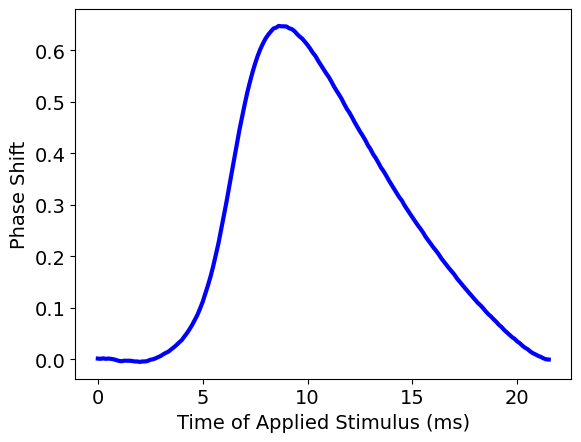

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 14,'lines.linewidth': 3}) 


# Function to round time to nearest 0.25
def round_to_nearest_0_125(x):
    return round(x * 4) / 4

# Define gating functions
def minf(V, bm, cm):
    return 0.5 * (1 + np.tanh((V - bm) / cm))

def winf(V, bw, cw):
    return 0.5 * (1 + np.tanh((V - bw) / cw))

def tauw(V, bw, cw):
    return 1 / np.cosh((V - bw) / (2 * cw))

# Modify Istim_function to accept a variable stimulus time
def Istim_function(t, stim_time):
    # Apply stimulus at the specified time
    if stim_time-0.25<t<stim_time+0.25:
        return 60  # Apply stimulus
    else:
        return 37.8  # Default stimulus

# Define Hodgkin-Huxley function
def hodgkinHuxley(t, x, p, stim_time):
    # Unpack parameters
    C, gfast, gslow, gleak, ENa, EK, Eleak, bm, cm, bw, cw, phiw = p
    
    # State variables
    V = x[0]
    w = x[1]
    
    # Compute Istim at time t using variable stim_time
    Istim = Istim_function(t, stim_time)
    
    # Compute derivatives
    dVdt = (Istim - gfast * minf(V, bm, cm) * (V - ENa) - gslow * w * (V - EK) - gleak * (V - Eleak)) / C
    dwdt = phiw * (winf(V, bw, cw) - w) / tauw(V, bw, cw)
    
    return np.array([dVdt, dwdt])

# Define simulation parameters
p = np.array([
    2,      # C
    20,     # gfast
    20,     # gslow
    2,      # gleak
    50,     # ENa
    -100,   # EK
    -70,    # Eleak
    -1.2,   # bm
    18,     # cm
    0,      # bw
    10,     # cw
    0.15    # phiw
])
stim_time=1000
# Define initial conditions
x0 = np.array([-20, 0.29])
t0, tfin = 0, 100  # Time range
solution = solve_ivp(
        hodgkinHuxley,                  # Function to integrate
        (t0, tfin),                     # Time interval (start, end)
        x0,                             # Initial conditions
        args=(p,stim_time),            # Pass p and stim_time
        max_step=1e-2,                  # Maximum step size
        dense_output=True               # Get continuous solution
    )

# Extract solution
t_values = solution.t
V_values, w_values = solution.y


# Find peaks in V (membrane potential)
peaks, _ = find_peaks(V_values, height=0)
peak_times = t_values[peaks]
# Define different stimulus times for testing
stim_times = np.arange(peak_times[0], peak_times[1], 0.125)  # Stimulus applied at 25, 27, 29, ..., 39 ms
phase_shift = []
# Run simulations for different stimulus times
for stim_time in stim_times:
    print(f"\nRunning simulation with stimulus time at {stim_time} ms")

    # Solve the system using solve_ivp
    solution = solve_ivp(
        hodgkinHuxley,                  # Function to integrate
        (t0, tfin),                     # Time interval (start, end)
        x0,                             # Initial conditions
        args=(p, stim_time),            # Pass p and stim_time
        max_step=1e-2,                  # Maximum step size
        dense_output=True               # Get continuous solution
    )

    # Extract solution
    t_values = solution.t
    V_values, w_values = solution.y


    # Find peaks in V (membrane potential)
    peaks, _ = find_peaks(V_values, height=0)  # height=0 means we're looking for peaks at any height

    # Extract the time values corresponding to the peaks
    peak_times = t_values[peaks]
    print(peak_times)
    true_period = peak_times[1] - peak_times[0]
    print(true_period)

    # peak_times_perturbed = peak_times[peak_times > 59.5]
    perturbed_period = peak_times[2] - peak_times[1]
    print(perturbed_period)
    phase_shift.append( (perturbed_period-true_period)/true_period)
plt.plot(stim_times-peak_times[0],phase_shift,'b')
plt.xlabel("Time of Applied Stimulus (ms)")
plt.ylabel("Phase Shift")
plt.show()